# Imports

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import os
import torch.optim.lr_scheduler as lr_scheduler
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# Directiry Setup

In [2]:
drive.mount('/content/drive')
os.chdir('/content/drive/Othercomputers/My MacBook Pro/Mega/Master Studies/Studying/Introduction to Deep Learning (18786)/Mini project/Miniproject')

Mounted at /content/drive


# Load Data

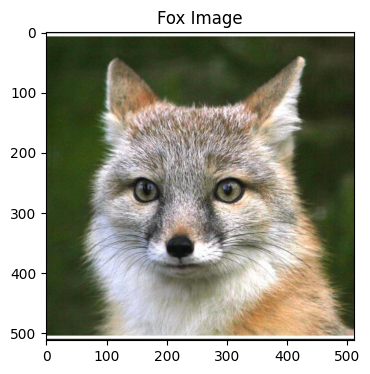

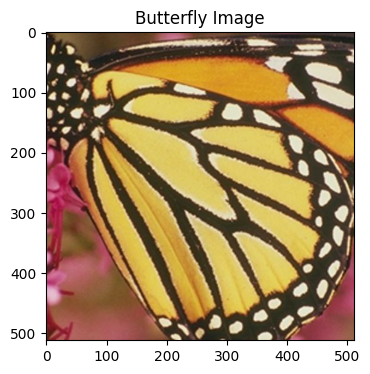

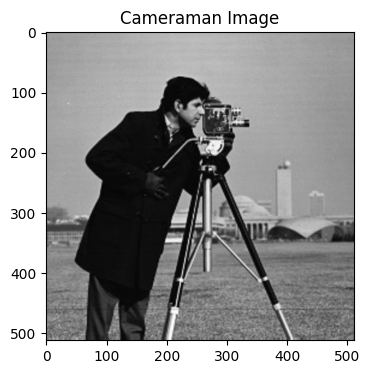

In [3]:
image_fox = plt.imread('data/image/fox.jpg')/255.0
plt.figure(figsize=(4, 4)) # initiate figure
plt.imshow(image_fox)
plt.title('Fox Image')
plt.show()

image_butterfly = plt.imread('data/image/butterfly.jpg')/255.0
plt.figure(figsize=(4, 4)) # initiate figure
plt.imshow(image_butterfly)
plt.title('Butterfly Image')
plt.show()

image_man = plt.imread('data/image/cameraman.jpg')/255.0
plt.figure(figsize=(4, 4)) # initiate figure
plt.imshow(image_man)
plt.title('Cameraman Image')
plt.show()

# cameraman image

## Load Data

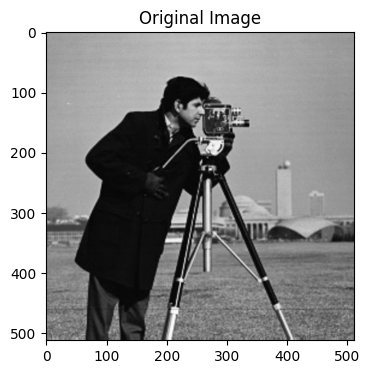

In [4]:
image_man = plt.imread('data/image/cameraman.jpg')/255.0
plt.figure(figsize=(4, 4)) # initiate figure
plt.imshow(image_man)
plt.title('Original Image')
plt.show()

## Prepare input and output data

In [5]:
## Input Features:
p = np.linspace(0, 1, 512)
q = np.linspace(0, 1, 512)
X = np.meshgrid(p, q)
X = np.stack(X, axis=-1).reshape(-1, 2).astype(np.float32)
X = torch.from_numpy(X) # to tensor

## Output labels
y = image_man.reshape(-1, image_man.shape[-1]).astype(np.float32)
y = torch.from_numpy(y) # to tensor

## Define network

In [13]:
class SineActivation(nn.Module):
    def __init__(self, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0

    def forward(self, x):
        return torch.sin(self.omega_0 * x)

class SIREN(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_features, 256),
            SineActivation(),
            nn.Linear(256, 512),
            SineActivation(),
            nn.Linear(512, 256),
            SineActivation(),
            nn.Linear(256, out_features)
        )

    def forward(self, x):
        return self.layers(x)

input_dim = 2
output_dim = 3

net = SIREN(input_dim, output_dim)


## Train and Test

In [14]:
## Use CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Define network:
net = SIREN(input_dim, output_dim).to(device)

## Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

## Train the model
num_epochs = 1000
num_samples = X.shape[0]
psnr_list = []
ssim_list = []

for epoch in range(num_epochs):

  # get data to device
  X = X.to(device)
  y = y.to(device)

  # Forward pass
  y_pred = net(X)
  loss = criterion(y_pred, y)

  # Backward pass and optimization
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Calculate PSNR and SSIM and append to list
  y_pred = y_pred.detach().cpu().numpy()
  # print(y_pred.shape)
  image_pred = y_pred.reshape((512, 512, 3))
  psnr = peak_signal_noise_ratio(image_man, image_pred)
  ssim = structural_similarity(image_man, image_pred, multichannel=True)
  psnr_list.append(psnr)
  ssim_list.append(ssim)

  # Print loss after every epoch
  print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, PSNR: {psnr:.4f}, SSIM: {ssim:.4f}')

<ipython-input-14-765fcca2d984>:36: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(image_man, image_pred)
<ipython-input-14-765fcca2d984>:37: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim = structural_similarity(image_man, image_pred, multichannel=True)
/usr/local/lib/python3.9/dist-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


Epoch [1/1000], Loss: 0.4642, PSNR: 3.3332, SSIM: -0.0018
Epoch [2/1000], Loss: 0.4552, PSNR: 3.4181, SSIM: -0.0020
Epoch [3/1000], Loss: 0.4472, PSNR: 3.4952, SSIM: -0.0020
Epoch [4/1000], Loss: 0.4385, PSNR: 3.5800, SSIM: -0.0020
Epoch [5/1000], Loss: 0.4298, PSNR: 3.6672, SSIM: -0.0019
Epoch [6/1000], Loss: 0.4238, PSNR: 3.7281, SSIM: -0.0021
Epoch [7/1000], Loss: 0.4148, PSNR: 3.8218, SSIM: -0.0020
Epoch [8/1000], Loss: 0.4082, PSNR: 3.8916, SSIM: -0.0020
Epoch [9/1000], Loss: 0.4007, PSNR: 3.9718, SSIM: -0.0016
Epoch [10/1000], Loss: 0.3946, PSNR: 4.0379, SSIM: -0.0021
Epoch [11/1000], Loss: 0.3875, PSNR: 4.1178, SSIM: -0.0020
Epoch [12/1000], Loss: 0.3803, PSNR: 4.1984, SSIM: -0.0018
Epoch [13/1000], Loss: 0.3741, PSNR: 4.2698, SSIM: -0.0017
Epoch [14/1000], Loss: 0.3685, PSNR: 4.3358, SSIM: -0.0017
Epoch [15/1000], Loss: 0.3631, PSNR: 4.3999, SSIM: -0.0015
Epoch [16/1000], Loss: 0.3580, PSNR: 4.4607, SSIM: -0.0016
Epoch [17/1000], Loss: 0.3521, PSNR: 4.5330, SSIM: -0.0013
Epoch 

## Show Results

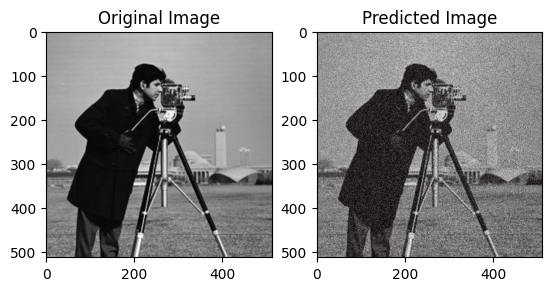

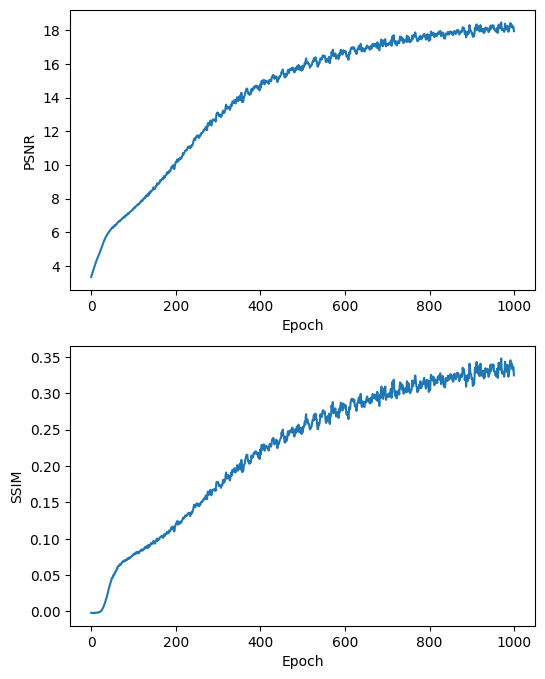

In [15]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(image_man)
ax[0].set_title('Original Image')
ax[1].imshow(image_pred)
ax[1].set_title('Predicted Image')
plt.show()

# Plot PSNR and SSIM against ground truth as a function of epochs
fig, ax = plt.subplots(2, 1, figsize=(6, 8))
ax[0].plot(psnr_list)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('PSNR')
ax[1].plot(ssim_list)
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('SSIM')
plt.show()

# Fox image

## Load Data

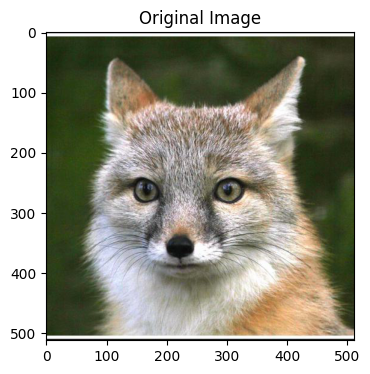

In [17]:
image_fox = plt.imread('data/image/fox.jpg')/255.0
plt.figure(figsize=(4, 4)) # initiate figure
plt.imshow(image_fox)
plt.title('Original Image')
plt.show()

## Prepare input and output data

In [18]:
## Input Features:
p = np.linspace(0, 1, 512)
q = np.linspace(0, 1, 512)
X = np.meshgrid(p, q)
X = np.stack(X, axis=-1).reshape(-1, 2).astype(np.float32)
X = torch.from_numpy(X) # to tensor

## Output labels
y = image_fox.reshape(-1, image_man.shape[-1]).astype(np.float32)
y = torch.from_numpy(y) # to tensor

## Define network

In [19]:
import torch
import torch.nn as nn

class SineActivation(nn.Module):
    def __init__(self, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0

    def forward(self, x):
        return torch.sin(self.omega_0 * x)

class SIREN(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_features, 256),
            SineActivation(),
            nn.Linear(256, 512),
            SineActivation(),
            nn.Linear(512, 256),
            SineActivation(),
            nn.Linear(256, out_features)
        )

    def forward(self, x):
        return self.layers(x)

input_dim = 2
output_dim = 3

net = SIREN(input_dim, output_dim)


## Train and Test

In [20]:
## Use CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Define network:
net = SIREN(input_dim, output_dim).to(device)

## Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

## Train the model
num_epochs = 1000
num_samples = X.shape[0]
psnr_list = []
ssim_list = []

for epoch in range(num_epochs):

  # get data to device
  X = X.to(device)
  y = y.to(device)

  # Forward pass
  y_pred = net(X)
  loss = criterion(y_pred, y)

  # Backward pass and optimization
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Calculate PSNR and SSIM and append to list
  y_pred = y_pred.detach().cpu().numpy()
  # print(y_pred.shape)
  image_pred = y_pred.reshape((512, 512, 3))
  psnr = peak_signal_noise_ratio(image_man, image_pred)
  ssim = structural_similarity(image_man, image_pred, multichannel=True)
  psnr_list.append(psnr)
  ssim_list.append(ssim)

  # Print loss after every epoch
  print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, PSNR: {psnr:.4f}, SSIM: {ssim:.4f}')

<ipython-input-20-765fcca2d984>:36: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(image_man, image_pred)
<ipython-input-20-765fcca2d984>:37: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim = structural_similarity(image_man, image_pred, multichannel=True)
/usr/local/lib/python3.9/dist-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


Epoch [1/1000], Loss: 0.4326, PSNR: 3.7296, SSIM: 0.0016
Epoch [2/1000], Loss: 0.4242, PSNR: 3.8147, SSIM: 0.0017
Epoch [3/1000], Loss: 0.4159, PSNR: 3.9074, SSIM: 0.0021
Epoch [4/1000], Loss: 0.4079, PSNR: 3.9866, SSIM: 0.0022
Epoch [5/1000], Loss: 0.3996, PSNR: 4.0838, SSIM: 0.0026
Epoch [6/1000], Loss: 0.3919, PSNR: 4.1709, SSIM: 0.0032
Epoch [7/1000], Loss: 0.3857, PSNR: 4.2433, SSIM: 0.0032
Epoch [8/1000], Loss: 0.3777, PSNR: 4.3276, SSIM: 0.0037
Epoch [9/1000], Loss: 0.3707, PSNR: 4.4186, SSIM: 0.0041
Epoch [10/1000], Loss: 0.3647, PSNR: 4.4876, SSIM: 0.0045
Epoch [11/1000], Loss: 0.3584, PSNR: 4.5638, SSIM: 0.0052
Epoch [12/1000], Loss: 0.3518, PSNR: 4.6508, SSIM: 0.0056
Epoch [13/1000], Loss: 0.3465, PSNR: 4.7199, SSIM: 0.0063
Epoch [14/1000], Loss: 0.3415, PSNR: 4.7814, SSIM: 0.0068
Epoch [15/1000], Loss: 0.3358, PSNR: 4.8558, SSIM: 0.0078
Epoch [16/1000], Loss: 0.3299, PSNR: 4.9342, SSIM: 0.0086
Epoch [17/1000], Loss: 0.3253, PSNR: 4.9978, SSIM: 0.0093
Epoch [18/1000], Loss: 

## Show Results

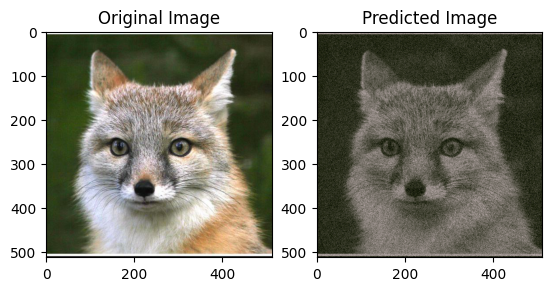

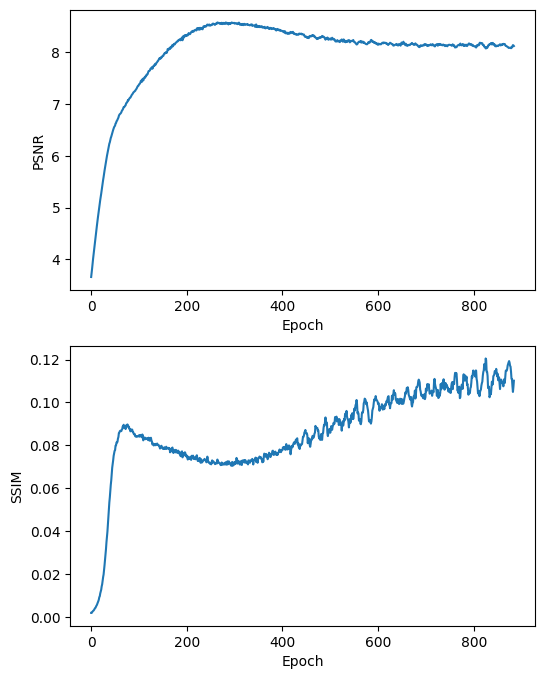

In [35]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(image_fox/image_fox.max())
ax[0].set_title('Original Image')
ax[1].imshow(image_pred/image_pred.max())
ax[1].set_title('Predicted Image')
plt.show()

# Plot PSNR and SSIM against ground truth as a function of epochs
fig, ax = plt.subplots(2, 1, figsize=(6, 8))
ax[0].plot(psnr_list)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('PSNR')
ax[1].plot(ssim_list)
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('SSIM')
plt.show()

# butterfly image

## Load Data

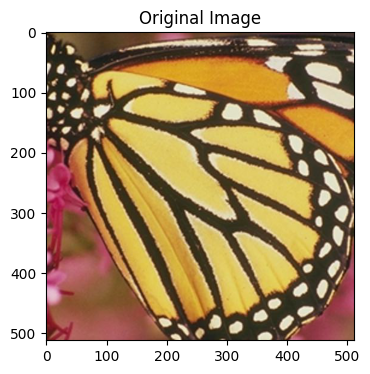

In [36]:
image_butter = plt.imread('data/image/butterfly.jpg')/255.0
plt.figure(figsize=(4, 4)) # initiate figure
plt.imshow(image_butter)
plt.title('Original Image')
plt.show()

## Prepare input and output data

In [37]:
## Input Features:
p = np.linspace(0, 1, 512)
q = np.linspace(0, 1, 512)
X = np.meshgrid(p, q)
X = np.stack(X, axis=-1).reshape(-1, 2).astype(np.float32)
X = torch.from_numpy(X) # to tensor

## Output labels
y = image_butter.reshape(-1, image_man.shape[-1]).astype(np.float32)
y = torch.from_numpy(y) # to tensor

## Define network

In [38]:
import torch
import torch.nn as nn

class SineActivation(nn.Module):
    def __init__(self, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0

    def forward(self, x):
        return torch.sin(self.omega_0 * x)

class SIREN(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_features, 256),
            SineActivation(),
            nn.Linear(256, 512),
            SineActivation(),
            nn.Linear(512, 256),
            SineActivation(),
            nn.Linear(256, out_features)
        )

    def forward(self, x):
        return self.layers(x)

input_dim = 2
output_dim = 3

net = SIREN(input_dim, output_dim)


## Train and Test

In [39]:
## Use CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Define network:
net = SIREN(input_dim, output_dim).to(device)

## Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

## Train the model
num_epochs = 1000
num_samples = X.shape[0]
psnr_list = []
ssim_list = []

for epoch in range(num_epochs):

  # get data to device
  X = X.to(device)
  y = y.to(device)

  # Forward pass
  y_pred = net(X)
  loss = criterion(y_pred, y)

  # Backward pass and optimization
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Calculate PSNR and SSIM and append to list
  y_pred = y_pred.detach().cpu().numpy()
  # print(y_pred.shape)
  image_pred = y_pred.reshape((512, 512, 3))
  psnr = peak_signal_noise_ratio(image_man, image_pred)
  ssim = structural_similarity(image_man, image_pred, multichannel=True)
  psnr_list.append(psnr)
  ssim_list.append(ssim)

  # Print loss after every epoch
  print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, PSNR: {psnr:.4f}, SSIM: {ssim:.4f}')

<ipython-input-39-765fcca2d984>:36: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(image_man, image_pred)
<ipython-input-39-765fcca2d984>:37: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim = structural_similarity(image_man, image_pred, multichannel=True)
/usr/local/lib/python3.9/dist-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


Epoch [1/1000], Loss: 0.4539, PSNR: 3.4631, SSIM: -0.0006
Epoch [2/1000], Loss: 0.4460, PSNR: 3.5357, SSIM: -0.0007
Epoch [3/1000], Loss: 0.4370, PSNR: 3.6281, SSIM: -0.0005
Epoch [4/1000], Loss: 0.4300, PSNR: 3.6969, SSIM: -0.0007
Epoch [5/1000], Loss: 0.4210, PSNR: 3.7871, SSIM: -0.0004
Epoch [6/1000], Loss: 0.4132, PSNR: 3.8712, SSIM: -0.0002
Epoch [7/1000], Loss: 0.4069, PSNR: 3.9397, SSIM: -0.0001
Epoch [8/1000], Loss: 0.3994, PSNR: 4.0207, SSIM: 0.0001
Epoch [9/1000], Loss: 0.3924, PSNR: 4.0971, SSIM: 0.0002
Epoch [10/1000], Loss: 0.3858, PSNR: 4.1756, SSIM: 0.0003
Epoch [11/1000], Loss: 0.3789, PSNR: 4.2534, SSIM: 0.0006
Epoch [12/1000], Loss: 0.3730, PSNR: 4.3210, SSIM: 0.0010
Epoch [13/1000], Loss: 0.3673, PSNR: 4.3944, SSIM: 0.0010
Epoch [14/1000], Loss: 0.3615, PSNR: 4.4571, SSIM: 0.0013
Epoch [15/1000], Loss: 0.3551, PSNR: 4.5367, SSIM: 0.0018
Epoch [16/1000], Loss: 0.3501, PSNR: 4.5986, SSIM: 0.0023
Epoch [17/1000], Loss: 0.3451, PSNR: 4.6651, SSIM: 0.0026
Epoch [18/1000],

## Show Results

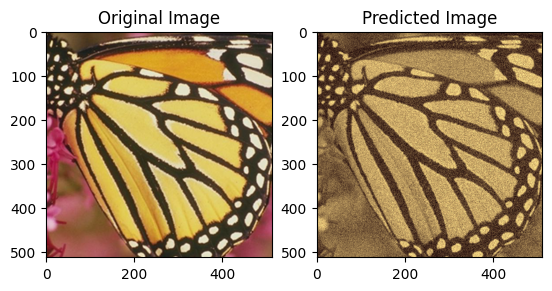

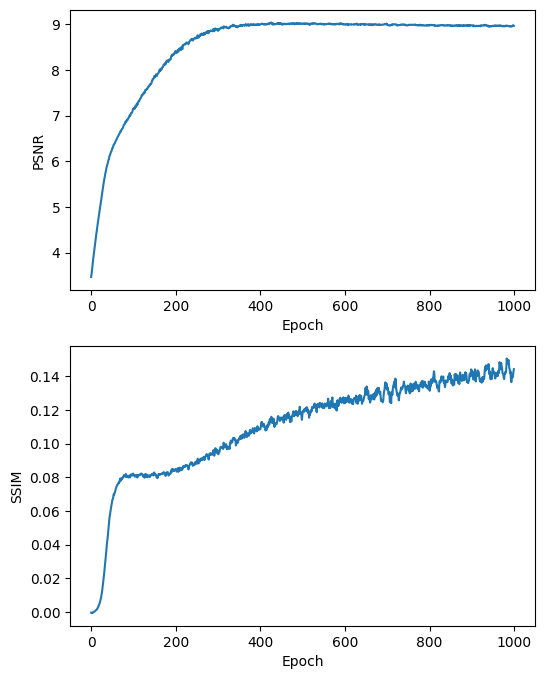

In [50]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(image_butter)
ax[0].set_title('Original Image')
ax[1].imshow(image_pred)
ax[1].set_title('Predicted Image')
plt.show()

# Plot PSNR and SSIM against ground truth as a function of epochs
fig, ax = plt.subplots(2, 1, figsize=(6, 8))
ax[0].plot(psnr_list)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('PSNR')
ax[1].plot(ssim_list)
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('SSIM')
plt.show()
